# 马尔可夫链天气预测系统
# 案例1：使用马尔可夫链预测未来天气

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 生成模拟天气数据

In [2]:
np.random.seed(42)
# 定义天气状态
weather_states = ['晴天', '阴天', '雨天']
n_states = len(weather_states)

# 定义真实的转移概率矩阵
true_transition_matrix = np.array([
    [0.7, 0.2, 0.1],  # 晴天 -> [晴天, 阴天, 雨天]
    [0.3, 0.4, 0.3],  # 阴天 -> [晴天, 阴天, 雨天]
    [0.2, 0.3, 0.5]   # 雨天 -> [晴天, 阴天, 雨天]
])

# 生成天气序列

In [3]:

def generate_weather_sequence(n_days, initial_state=0):
    """生成n天的天气序列"""
    sequence = [initial_state]
    current_state = initial_state
    
    for _ in range(n_days - 1):
        # 根据当前状态和转移概率选择下一个状态
        next_state = np.random.choice(
            n_states, 
            p=true_transition_matrix[current_state]
        )
        sequence.append(next_state)
        current_state = next_state
    
    return sequence

In [4]:
# 生成30天的历史数据
historical_days = 30
weather_sequence = generate_weather_sequence(historical_days)
weather_names = [weather_states[i] for i in weather_sequence]

# 创建数据框
df = pd.DataFrame({
    '日期': pd.date_range('2025-01-01', periods=historical_days),
    '天气状态': weather_names,
    '状态编码': weather_sequence
})

print("历史天气数据（前10天）：")
print(df.head(10))
print(f"\n数据形状：{df.shape}")

历史天气数据（前10天）：
          日期 天气状态  状态编码
0 2025-01-01   晴天     0
1 2025-01-02   晴天     0
2 2025-01-03   雨天     2
3 2025-01-04   雨天     2
4 2025-01-05   雨天     2
5 2025-01-06   晴天     0
6 2025-01-07   晴天     0
7 2025-01-08   晴天     0
8 2025-01-09   阴天     1
9 2025-01-10   阴天     1

数据形状：(30, 3)


# 2. 估计转移概率矩阵

In [5]:

def estimate_transition_matrix(sequence):
    """从观察序列估计转移概率矩阵"""
    n_states = len(set(sequence))
    transition_counts = np.zeros((n_states, n_states))
    
    # 统计转移次数
    for i in range(len(sequence) - 1):
        current_state = sequence[i]
        next_state = sequence[i + 1]
        transition_counts[current_state, next_state] += 1
    
    # 计算转移概率
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(n_states):
        row_sum = transition_counts[i].sum()
        if row_sum > 0:
            transition_matrix[i] = transition_counts[i] / row_sum
        else:
            # 如果某个状态没有出现，使用均匀分布
            transition_matrix[i] = 1.0 / n_states
    
    return transition_matrix, transition_counts

# 估计转移概率矩阵

In [6]:
estimated_matrix, counts_matrix = estimate_transition_matrix(weather_sequence)

print("\n转移次数矩阵：")
counts_df = pd.DataFrame(
    counts_matrix,
    index=weather_states,
    columns=weather_states
)
print(counts_df)

print("\n估计的转移概率矩阵：")
prob_df = pd.DataFrame(
    estimated_matrix,
    index=weather_states,
    columns=weather_states
)
print(prob_df.round(3))


转移次数矩阵：
      晴天   阴天   雨天
晴天  15.0  2.0  2.0
阴天   2.0  1.0  1.0
雨天   2.0  1.0  3.0

估计的转移概率矩阵：
       晴天     阴天     雨天
晴天  0.789  0.105  0.105
阴天  0.500  0.250  0.250
雨天  0.333  0.167  0.500


# 3. 可视化转移概率矩阵

Text(0.5, 1.0, '状态转移图')

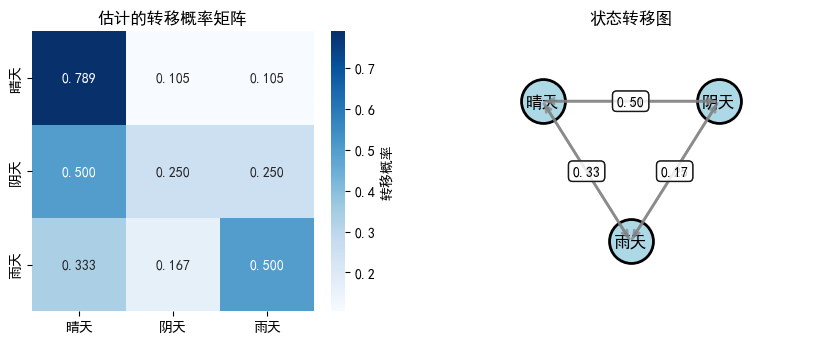

In [7]:
plt.figure(figsize=(10, 8))

# 子图1：热力图
plt.subplot(2, 2, 1)
sns.heatmap(estimated_matrix, annot=True, fmt='.3f', 
            xticklabels=weather_states, yticklabels=weather_states,
            cmap='Blues', cbar_kws={'label': '转移概率'})
plt.title('估计的转移概率矩阵')

# 子图2：状态转移图（简化版）
plt.subplot(2, 2, 2)
G = np.zeros((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        if estimated_matrix[i, j] > 0.1:  # 只显示概率>0.1的转移
            G[i, j] = estimated_matrix[i, j]

pos = {0: (0, 1), 1: (1, 1), 2: (0.5, 0)}  # 节点位置
for i in range(n_states):
    plt.scatter(pos[i][0], pos[i][1], s=1000, c='lightblue', 
                edgecolors='black', linewidth=2)
    plt.text(pos[i][0], pos[i][1], weather_states[i], 
             ha='center', va='center', fontsize=12)

# 绘制箭头
for i in range(n_states):
    for j in range(n_states):
        if G[i, j] > 0:
            if i != j:
                plt.annotate('', xy=pos[j], xytext=pos[i],
                           arrowprops=dict(arrowstyle='->', lw=2,
                                         color='gray', alpha=0.7))
                # 添加概率标签
                mid_x = (pos[i][0] + pos[j][0]) / 2
                mid_y = (pos[i][1] + pos[j][1]) / 2
                plt.text(mid_x, mid_y, f'{G[i,j]:.2f}', 
                        ha='center', va='center', fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.3', 
                                facecolor='white', alpha=0.8))

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.axis('off')
plt.title('状态转移图')

# 4. 天气预测

In [8]:
def predict_weather(current_state, transition_matrix, n_days):
    """预测未来n天的天气"""
    predictions = []
    state_probs = []
    
    # 初始状态概率向量
    current_prob = np.zeros(len(weather_states))
    current_prob[current_state] = 1.0
    
    for day in range(n_days):
        # 计算下一天的状态概率
        current_prob = current_prob @ transition_matrix
        state_probs.append(current_prob.copy())
        
        # 选择最可能的状态作为预测
        predicted_state = np.argmax(current_prob)
        predictions.append(predicted_state)
    
    return predictions, state_probs

# 预测未来7天的天气

In [9]:
current_weather = weather_sequence[-1]  # 使用最后一天的天气作为当前状态
forecast_days = 7
predictions, probabilities = predict_weather(current_weather, estimated_matrix, forecast_days)

# 创建预测结果数据框
forecast_df = pd.DataFrame({
    '预测日期': pd.date_range(df['日期'].iloc[-1] + pd.Timedelta(days=1), 
                           periods=forecast_days),
    '预测天气': [weather_states[i] for i in predictions],
    '晴天概率': [p[0] for p in probabilities],
    '阴天概率': [p[1] for p in probabilities],
    '雨天概率': [p[2] for p in probabilities]
})

print("\n未来7天天气预测：")
print(forecast_df.round(3))


未来7天天气预测：
        预测日期 预测天气   晴天概率   阴天概率   雨天概率
0 2025-01-31   晴天  0.789  0.105  0.105
1 2025-02-01   晴天  0.711  0.127  0.162
2 2025-02-02   晴天  0.679  0.134  0.188
3 2025-02-03   晴天  0.665  0.136  0.199
4 2025-02-04   晴天  0.659  0.137  0.203
5 2025-02-05   晴天  0.657  0.138  0.205
6 2025-02-06   晴天  0.656  0.138  0.206


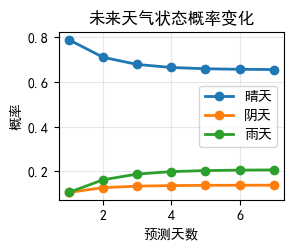

In [10]:
# 子图3：预测概率变化
plt.subplot(2, 2, 3)
days = range(1, forecast_days + 1)
for i, state in enumerate(weather_states):
    probs = [p[i] for p in probabilities]
    plt.plot(days, probs, marker='o', label=state, linewidth=2)

plt.xlabel('预测天数')
plt.ylabel('概率')
plt.title('未来天气状态概率变化')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. 计算稳态分布

In [11]:

def compute_steady_state(transition_matrix):
    """计算马尔可夫链的稳态分布"""
    # 求解 π = π * P
    # 等价于求解 (P^T - I)π = 0, 且 sum(π) = 1
    n = transition_matrix.shape[0]
    A = transition_matrix.T - np.eye(n)
    A = np.vstack([A, np.ones(n)])
    b = np.zeros(n + 1)
    b[-1] = 1
    
    # 使用最小二乘法求解
    steady_state = np.linalg.lstsq(A, b, rcond=None)[0]
    return steady_state

steady_state = compute_steady_state(estimated_matrix)

print("\n稳态分布：")
for i, state in enumerate(weather_states):
    print(f"{state}: {steady_state[i]:.3f}")


稳态分布：
晴天: 0.655
阴天: 0.138
雨天: 0.207


# 子图4：长期预测vs稳态

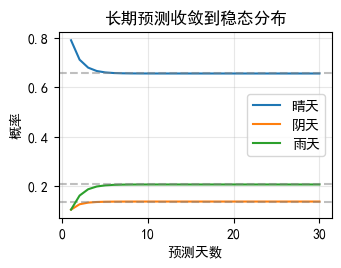

In [12]:

plt.subplot(2, 2, 4)
long_term_days = 30
_, long_term_probs = predict_weather(current_weather, estimated_matrix, long_term_days)

for i, state in enumerate(weather_states):
    probs = [p[i] for p in long_term_probs]
    plt.plot(range(1, long_term_days + 1), probs, label=f'{state}')
    plt.axhline(y=steady_state[i], color='gray', linestyle='--', alpha=0.5)

plt.xlabel('预测天数')
plt.ylabel('概率')
plt.title('长期预测收敛到稳态分布')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. 模型评估

In [13]:
def evaluate_markov_property(sequence):
    """检验序列的马尔可夫性"""
    # 简单的卡方检验思路
    n = len(sequence)
    
    # 统计一阶转移
    first_order_counts = np.zeros((n_states, n_states))
    for i in range(n - 1):
        first_order_counts[sequence[i], sequence[i+1]] += 1
    
    # 统计二阶转移（考虑前两个状态）
    second_order_counts = {}
    for i in range(n - 2):
        key = (sequence[i], sequence[i+1])
        next_state = sequence[i+2]
        if key not in second_order_counts:
            second_order_counts[key] = np.zeros(n_states)
        second_order_counts[key][next_state] += 1
    
    print("\n马尔可夫性检验：")
    print("如果满足马尔可夫性，P(X_t+1|X_t) 应该与 P(X_t+1|X_t,X_t-1) 相似")
    
    # 比较一阶和二阶转移概率
    for (prev_prev, prev), counts in second_order_counts.items():
        if counts.sum() > 5:  # 只考虑有足够观察的情况
            second_order_prob = counts / counts.sum()
            first_order_prob = estimated_matrix[prev]
            diff = np.abs(second_order_prob - first_order_prob).mean()
            print(f"\n从 ({weather_states[prev_prev]},{weather_states[prev]}) 出发:")
            print(f"  二阶转移概率: {second_order_prob.round(3)}")
            print(f"  一阶转移概率: {first_order_prob.round(3)}")
            print(f"  平均差异: {diff:.3f}")

evaluate_markov_property(weather_sequence)


马尔可夫性检验：
如果满足马尔可夫性，P(X_t+1|X_t) 应该与 P(X_t+1|X_t,X_t-1) 相似

从 (晴天,晴天) 出发:
  二阶转移概率: [0.786 0.143 0.071]
  一阶转移概率: [0.789 0.105 0.105]
  平均差异: 0.025


In [14]:
# 7. 生成更多数据进行验证
print("\n\n使用更多数据验证模型：")
validation_sequence = generate_weather_sequence(1000)
validation_matrix, _ = estimate_transition_matrix(validation_sequence)

print("大样本估计的转移概率矩阵：")
print(pd.DataFrame(validation_matrix, 
                  index=weather_states, 
                  columns=weather_states).round(3))

print("\n与真实矩阵的比较：")
print("平均绝对误差：", np.abs(validation_matrix - true_transition_matrix).mean().round(4))

# # 保存结果
# results = {
#     'historical_data': df,
#     'transition_matrix': estimated_matrix,
#     'forecast': forecast_df,
#     'steady_state': steady_state
# }

# print("\n分析完成！主要结果已保存在 results 字典中。")



使用更多数据验证模型：
大样本估计的转移概率矩阵：
       晴天     阴天     雨天
晴天  0.701  0.175  0.123
阴天  0.341  0.364  0.295
雨天  0.174  0.308  0.518

与真实矩阵的比较：
平均绝对误差： 0.0204
